In [1]:
import numpy as np

dec_data = np.loadtxt('./Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('./Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('./Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('./Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_data.shape)
print(dec_train.shape)
print(dec_val.shape)
print(dec_test.shape)

(149, 254750)
(149, 203800)
(149, 50950)
(149, 139587)


In [2]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
# from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
# from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [3]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Calculate attention scores
        e = tf.keras.backend.dot(x, self.W)

        # Calculate attention weights using softmax activation
        a = tf.keras.activations.softmax(e, axis=-2)

        # Apply attention weights to the input sequence
        output = x * a

        # Sum the weighted inputs to get the attention output
        output = tf.keras.backend.sum(output, axis=-2)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape


In [5]:
k = 4 # which prediction horizon
T = 100 # the length of a single input i. e lookback_timestep THIS HYPERPARAMETER IS FINE TUNED FOR MODEL CONVERGENCE
n_hiddens = 64
checkpoint_filepath = './BiADLOBmodel_tensorflow2/weights'

In [6]:
# # Training Dataset Shrinking
# dec_train = dec_train[:,:50000]
print(dec_train.shape)
trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
print(trainX_CNN.shape, trainY_CNN.shape)

(149, 203800)
(203701, 100, 40, 1) (203701, 3)


In [7]:
# Testing Dataset Shrinking
# dec_test = dec_test[:,:20000]
print(dec_test.shape)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)
print(testX_CNN.shape, testY_CNN.shape)

(149, 139587)
(139488, 100, 40, 1) (139488, 3)


In [8]:

# Validation Dataset Shrinking
# dec_val = dec_val[:,:10000]
print(dec_val.shape)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
print(valX_CNN.shape, valY_CNN.shape)

(149, 50950)
(50851, 100, 40, 1) (50851, 3)


In [9]:
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203701, 100, 40, 1) (203701, 3)
(50851, 100, 40, 1) (50851, 3)
(139488, 100, 40, 1) (139488, 3)


In [10]:
from keras.layers import Bidirectional
def create_biadeeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))

    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)

    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_bi_lstm = Bidirectional(LSTM(number_of_lstm, return_sequences=True))(conv_reshape)

    # add an attention layer
    attention_output = AttentionLayer()(conv_bi_lstm)

    # build the output layer
    out = Dense(3, activation='softmax')(attention_output)

    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

biadeeplob = create_biadeeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
biadeeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 40, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 20, 32)          96        ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 100, 20, 32)          0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 100, 20, 32)          4128      ['leaky_re_lu[0][0]']         
                                                                                              

In [11]:
%%time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

biadeeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN),
            epochs=200, batch_size=128, verbose=2, callbacks=[model_checkpoint_callback])

Epoch 1/200
1592/1592 - 1224s - loss: 1.0240 - accuracy: 0.4196 - val_loss: 1.0867 - val_accuracy: 0.3723 - 1224s/epoch - 769ms/step
Epoch 2/200
1592/1592 - 1162s - loss: 1.0142 - accuracy: 0.4311 - val_loss: 1.1212 - val_accuracy: 0.3712 - 1162s/epoch - 730ms/step
Epoch 3/200
1592/1592 - 1177s - loss: 0.9382 - accuracy: 0.5094 - val_loss: 0.9983 - val_accuracy: 0.4895 - 1177s/epoch - 739ms/step
Epoch 4/200
1592/1592 - 1170s - loss: 0.8199 - accuracy: 0.6075 - val_loss: 0.9082 - val_accuracy: 0.5649 - 1170s/epoch - 735ms/step
Epoch 5/200
1592/1592 - 1173s - loss: 0.6426 - accuracy: 0.7275 - val_loss: 0.8265 - val_accuracy: 0.6233 - 1173s/epoch - 737ms/step
Epoch 6/200
1592/1592 - 1192s - loss: 0.5486 - accuracy: 0.7799 - val_loss: 0.7782 - val_accuracy: 0.6631 - 1192s/epoch - 749ms/step
Epoch 7/200
1592/1592 - 1191s - loss: 0.4943 - accuracy: 0.8071 - val_loss: 0.7862 - val_accuracy: 0.6765 - 1191s/epoch - 748ms/step
Epoch 8/200
1592/1592 - 1195s - loss: 0.4553 - accuracy: 0.8249 - val

In [12]:
biadeeplob.load_weights(checkpoint_filepath)
pred = biadeeplob.predict(testX_CNN)

4359/4359 [==============================] - 275s 57ms/step


In [13]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.7600223675154852
              precision    recall  f1-score   support

           0     0.7717    0.7212    0.7456     47915
           1     0.8353    0.7541    0.7926     48050
           2     0.6862    0.8093    0.7427     43523

    accuracy                         0.7600    139488
   macro avg     0.7644    0.7615    0.7603    139488
weighted avg     0.7669    0.7600    0.7609    139488



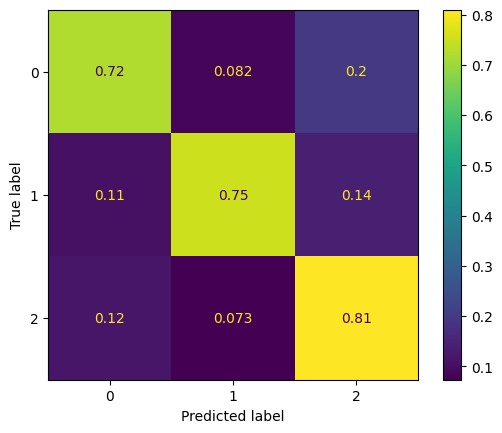

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
c = confusion_matrix(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()